# Prerequisites

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

Using TensorFlow backend.


# Prepare Data

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [3]:
for price in prices:
    price.scaled, price.scaler = data_transform(price, method=None)
    price.train, price.validate, price.train2, price.test = data_split(price.scaled)
    print(price.train.size, price.validate.size, price.test.size)

259 85 85
259 85 85
259 85 85


# ARIMA

## Define functions
- arima_fit
- arima_forecast
- arima_walk_forward

In [4]:
def arima_fit(data, config):
    order, sorder, trend = config
    return pm.arima.ARIMA(order, sorder, trend=trend).fit(data)

def arima_forecast(model_fitted, data, n_forecast=4):
    scaler = getattr(data, "scaler")
    df = pd.DataFrame(model_fitted.predict(n_forecast),
                      columns=["yhat_scaled"])
    df['yhat'] = scaler.inverse_transform(df)
    return df['yhat']

def arima_walk_forward(data, config, search_mode=False, n_forecast=4):
    train, test = select_traintest(data, search_mode)
    n_test = test.shape[0]
    n_yhat = n_test-n_forecast+1
    yhat = np.empty((n_yhat, n_forecast))
    
    history = train
    model_fitted = arima_fit(history, config)
    yhat[0] = arima_forecast(model_fitted, data, n_forecast)
    
    for i in range(1, n_yhat):
        model_fitted = model_fitted.update(test.iloc[i])
        yhat[i] = arima_forecast(model_fitted, data, n_forecast)
        history = history.append(test.iloc[i])

    yhat = pd.DataFrame(yhat,
                        columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                        index=test.iloc[:n_yhat,].index)
    
    return yhat

## Generate Parameter Grid

In [5]:
p = list(range(3))
q = list(range(3))
P = [0, 1]
Q = [0, 1]
t = ['c']
m = 12
order = model_configs(p, [1], q)
sorder = model_configs(P, [0], Q, [12])
arima_configs = model_configs(order, sorder, t)
arima_model = [arima_fit, arima_forecast, arima_walk_forward, arima_configs]

In [6]:
%%time
n_forecast=4
for price in prices:
    price.arima_grid_result, price.arima_config = grid_search(price, arima_model, n_forecast=n_forecast)
    price.arima_yhat = forecast(price, arima_model, price.arima_config, n_forecast=n_forecast)

{'(0, 1, 0)-(0, 0, 0, 12)-c': {'rmse': 991.5991, 'mae': 522.6669, 'mape': 0.0405}}
{'(0, 1, 0)-(0, 0, 1, 12)-c': {'rmse': 1007.375, 'mae': 552.2922, 'mape': 0.0428}}
{'(0, 1, 0)-(1, 0, 0, 12)-c': {'rmse': 1011.8097, 'mae': 561.4654, 'mape': 0.0435}}
{'(0, 1, 0)-(1, 0, 1, 12)-c': {'rmse': 998.6357, 'mae': 537.0852, 'mape': 0.041}}
{'(0, 1, 1)-(0, 0, 0, 12)-c': {'rmse': 978.569, 'mae': 538.6453, 'mape': 0.0417}}
{'(0, 1, 1)-(0, 0, 1, 12)-c': {'rmse': 993.2788, 'mae': 561.0431, 'mape': 0.0433}}
{'(0, 1, 1)-(1, 0, 0, 12)-c': {'rmse': 997.2983, 'mae': 565.5128, 'mape': 0.0436}}
{'(0, 1, 1)-(1, 0, 1, 12)-c': {'rmse': 982.7769, 'mae': 532.8796, 'mape': 0.0406}}
{'(0, 1, 2)-(0, 0, 0, 12)-c': {'rmse': 1022.5247, 'mae': 552.1516, 'mape': 0.0425}}
{'(0, 1, 2)-(0, 0, 1, 12)-c': {'rmse': 1035.6452, 'mae': 576.9977, 'mape': 0.0444}}
{'(0, 1, 2)-(1, 0, 0, 12)-c': {'rmse': 1037.5017, 'mae': 581.1296, 'mape': 0.0446}}
{'(0, 1, 2)-(1, 0, 1, 12)-c': {'rmse': 1022.8089, 'mae': 543.9119, 'mape': 0.0412}}
{

In [7]:
path = '../results/result_arima_4.pkl'

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    result = dict()
    for price in prices:
        result[price.meta.abb] = [price.arima_grid_result, price.arima_config, price.arima_yhat]
    joblib.dump(result, path)

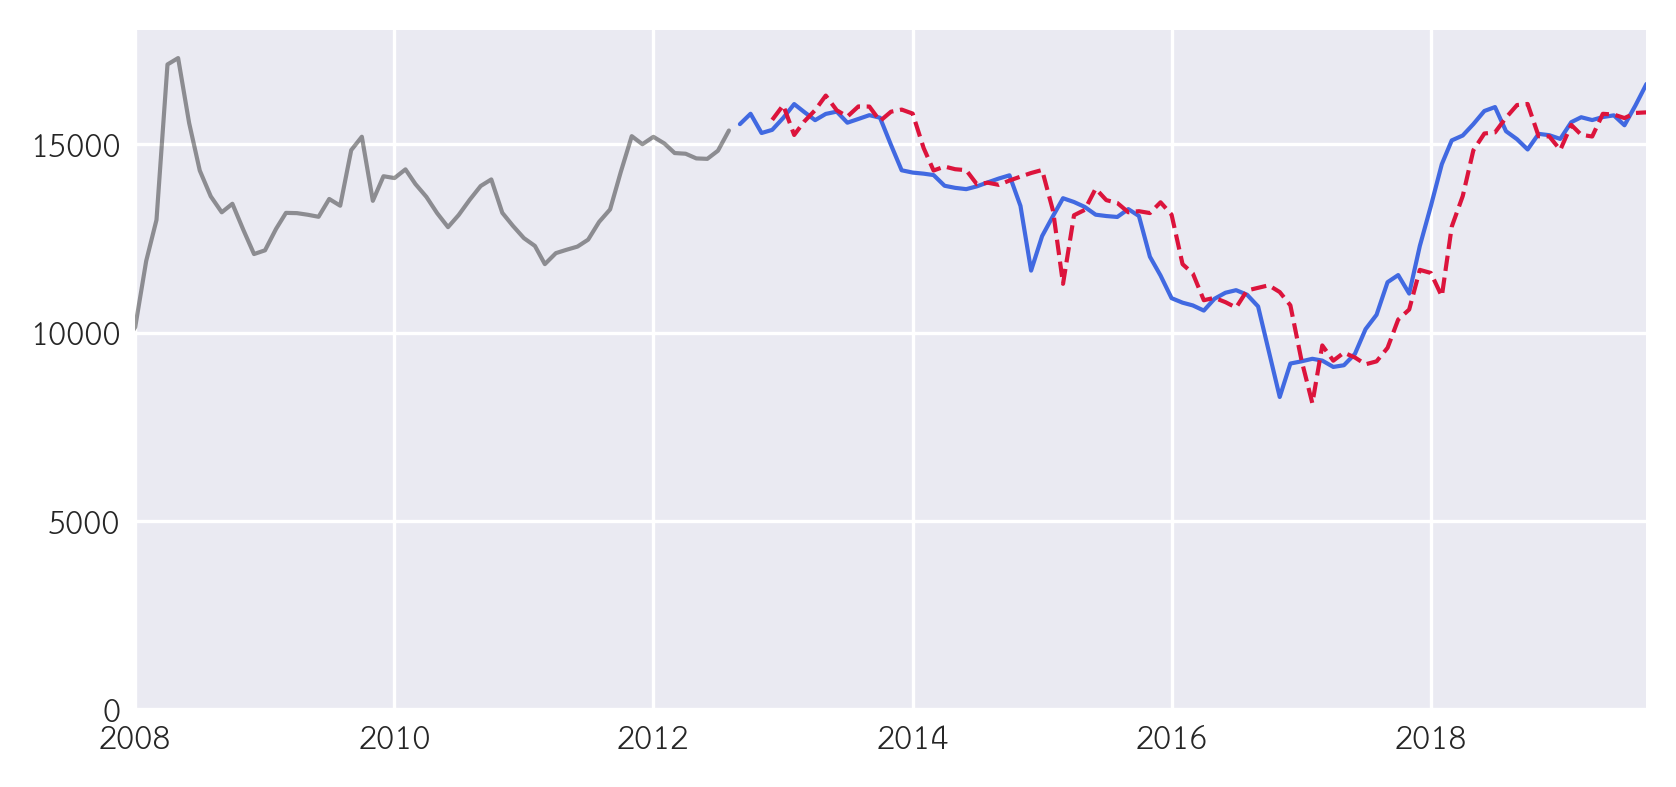

In [8]:
plot_fcast(hml, 'arima', step=4)

In [9]:
model_measure(hml, hml.arima_yhat, [""])

,rmse,mae,mape
config,,,
,698.6862,424.1819,0.0345
